In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sys.path.append('../')
from delight.utils import *
from delight.io import *

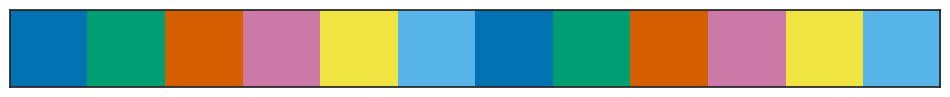

In [3]:
# Setting style
from matplotlib import rcParams
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
sns.set_style('white')
sns.set_palette("colorblind", 12) 
sns.palplot(sns.color_palette())
colTF = sns.color_palette()[2] 
colGP = sns.color_palette()[0]
colGP2 = sns.color_palette()[5]

In [4]:
%cd '/Users/bl/Dropbox/repos/PhotoZviaGP/'
params = parseParamFile('parameters.cfg', verbose=False)
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms\
    = readBandCoefficients(params)
bandNames = params['bandNames']
numBands, numCoefs = bandCoefAmplitudes.shape

/Users/bl/Dropbox/repos/PhotoZviaGP


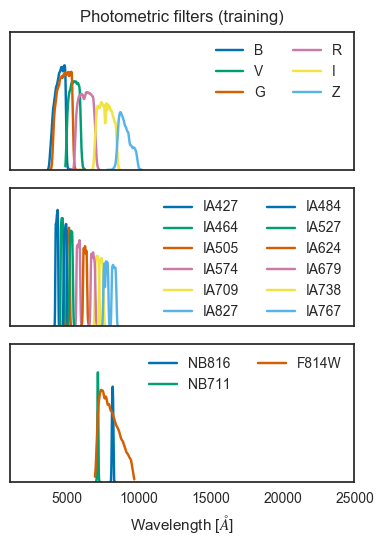

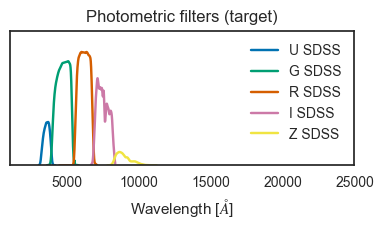

In [5]:
subaru_broadbands = [
    'B', 'V', 'G', 'R', 'I', 'Z']
subaru_interbands = [
    'IA427', 'IA464', 'IA505', 'IA574', 
    'IA709', 'IA827', 'IA484', 'IA527',
    'IA624', 'IA679', 'IA738', 'IA767']
subaru_narrowbands = [
    'NB816', 'NB711']
sdss_bands = ['U_SDSS', 'G_SDSS', 'R_SDSS', 'I_SDSS', 'Z_SDSS']
ctiokpno_bands = ['K']
hst_dands = ['F814W']
ukirt_bands = ['J']
fig, axs = plt.subplots(3, 1, figsize=(4, 5.6), sharex=True)
fig2, ax = plt.subplots(1, 1, figsize=(4, 2.45), sharex=True)
for ib, bnm in enumerate(params['bandNames']):
    amps, mus, sigs = bandCoefAmplitudes[ib, :], bandCoefPositions[ib, :], bandCoefWidths[ib, :]
    x = np.linspace(np.min(mus-2*sigs), np.max(mus+2*sigs), 1000)
    y = np.sum(amps[None, :] * np.exp(-0.5*((x[:, None]-mus[None, :])/sigs[None, :])**2), axis=1)
    if bnm in subaru_broadbands:
        theax = axs[0]
    elif bnm in subaru_interbands:
        theax = axs[1]
    elif bnm in sdss_bands:
        theax = ax
    elif bnm in subaru_narrowbands + hst_dands:
        theax = axs[2]
    else:
        theax = None
    if theax is not None:
        theax.plot(x, y, label=bnm.replace('_', ' '))
for tax in axs:
    tax.set_yticks([])
    tax.legend(ncol=2)
    tax.set_ylim([0, tax.get_ylim()[1]*1.1])
    tax.set_xlim([1e3, 2.5e4])
ax.set_yticks([])
ax.legend()
ax.set_xlim([1e3, 2.5e4])
ax.set_ylim([0, ax.get_ylim()[1]*1.15])
axs[0].set_title(r'Photometric filters (training)', y=1.02)
ax.set_title(r'Photometric filters (target)', y=1.02)
axs[-1].set_xlabel(r'Wavelength [$\AA$]')
ax.set_xlabel(r'Wavelength [$\AA$]')
fig.tight_layout()
fig2.tight_layout()
fig.savefig('./paper/filters_training.pdf')
fig2.savefig('./paper/filters_target.pdf')

In [6]:
fluxredshifts = np.loadtxt(params['target_catFile'])
fluxredshifts_train = np.loadtxt(params['training_catFile'])

bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,\
            refBandColumn = readColumnPositions(params, prefix='target_')
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)

In [7]:
dir_seds = params['templates_directory']
dir_filters = params['bands_directory']
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']
nt = len(sed_names)
f_mod = np.zeros((redshiftGrid.size, nt,
                  len(params['bandNames'])))
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name +
                                '_fluxredshiftmod.txt')
#    f_mod[:, t, :] /= np.mean(f_mod[:, t, :], axis=1)[:, None]

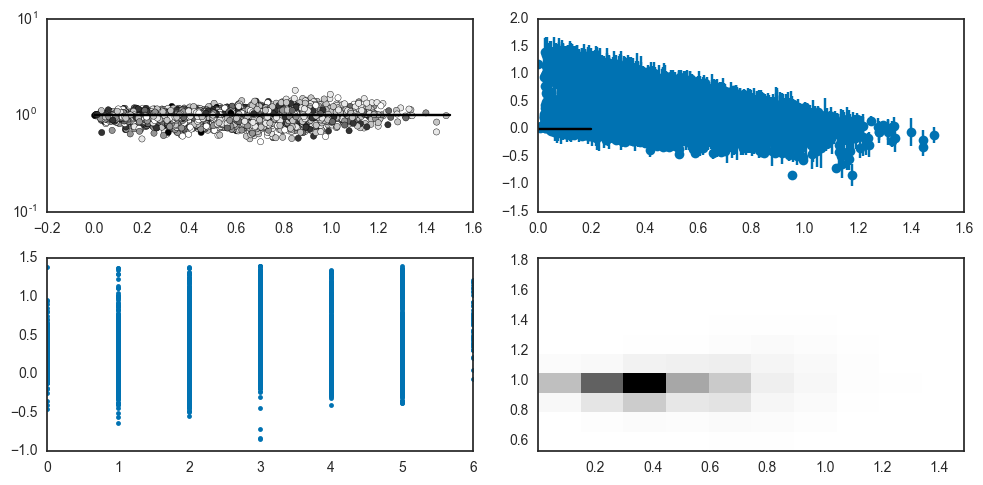

In [8]:
from delight.utils import *
DL = approx_DL()
numObjectsTarget = np.sum(1 for line in open(params['target_catFile']))
trainingDataIter = getDataFromFile(params, 0, numObjectsTarget,
                                   prefix="target_", getXY=False)
loc = -1
dat = np.zeros((numObjectsTarget, 9))  # z, ellhat, ellML[tbest], chi2, chi2marg, t, ell_av
for z, ell, bands, fluxes, fluxesVar, bCV, fCV, fvCV in trainingDataIter:
    loc += 1
    themod = np.zeros((1, nt, bands.size))
    for ib, b in enumerate(bands):
        for it in range(nt):
            themod[0, it, ib] = np.interp(z, redshiftGrid, f_mod[:, it, b])
    refB = 2
    fac = 4
    ell_hat = fluxes[refB] * norms[refB] * fac #* 4 * np.pi * DL(z)**2. * (1+z) 
    ell_hat_z = fluxes[refB] * norms[refB] * 4 * np.pi
    ell_hat_z *= DL(redshiftGrid)**2. * (1+redshiftGrid) * fac
    ell_hat_z = ell_hat_z[:, None]
    ell_var = (ell_hat_z*1e0)**2
    fluxesVar += (fluxes * 1e-2)**2
    ellML = approx_flux_likelihood( fluxes, fluxesVar, themod,
            marginalizeEll=True, normalized=True, returnEllML=True)[0]
    like = approx_flux_likelihood( fluxes, fluxesVar, themod,
            marginalizeEll=False, normalized=False, returnEllML=False)[0]
    likemarg = approx_flux_likelihood( fluxes, fluxesVar, themod,
            marginalizeEll=True, normalized=False, returnEllML=False)[0]
    
    ellML2 = approx_flux_likelihood( fluxes, fluxesVar, f_mod[:, :, bands],
            marginalizeEll=True, normalized=True, returnEllML=True)
    like2 = approx_flux_likelihood( fluxes, fluxesVar, f_mod[:, :, bands],
            marginalizeEll=False, normalized=False, returnEllML=False)
    likemarg2 = approx_flux_likelihood( fluxes, fluxesVar, f_mod[:, :, bands],
            marginalizeEll=True, normalized=False, returnEllML=False)
    
    t1 = np.argmax(likemarg)
    ell_hat /= themod[0, t1, refB]
    pdf = likemarg2.sum(axis=1)
    z_mean = np.average(redshiftGrid, weights=pdf)
    z_std = np.sqrt(np.average((redshiftGrid-z_mean)**2, weights=pdf))
    weights = like / np.sum(like)
    ell_av = np.sum(ellML * weights)
    dat[loc, :] = z, ell_hat, ellML[t1], like[t1], likemarg[t1], t1, ell_av, z_mean, z_std
    
z = dat[:, 0]
like = dat[:, 4]
chi2 = -2*np.log(like)
ratio = dat[:, 1] / dat[:, 2] 
ratio2 = dat[:, 1] / dat[:, 6] 
z_mean, z_std = dat[:, 7], dat[:, 8] 
ind = z > 0.01
t = dat[:, 5]

fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs = axs.ravel()
axs[0].scatter(z, ratio, c=t)
axs[0].plot([0, 1.5], [1, 1], c='k')
axs[0].set_yscale('log')
#axs[1].scatter(z[ind], ratio2[ind], c=t[ind])
#axs[1].plot([0, 1.5], [1, 1], c='k')
axs[1].errorbar(z, z_mean-z, z_std, fmt="o")
axs[1].plot([0, 0.2], [0, 0], "k")

#axs[1].set_yscale('log')
axs[2].errorbar(t, z_mean - z, fmt=".")
ind = np.isfinite(chi2)
#axs[3].scatter(z[ind], chi2[ind] / 5, marker=".")
#axs[3].set_yscale('log')
axs[3].hist2d(z, ratio)
fig.tight_layout()

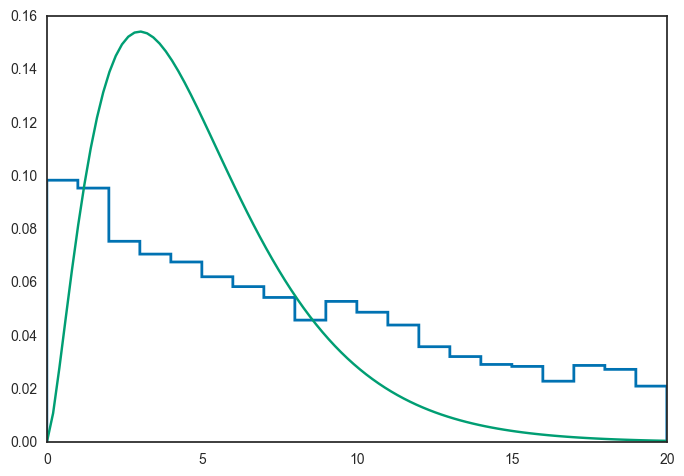

In [9]:
import scipy.stats
x = np.linspace(0, 20, 100)
y = scipy.stats.chi2.pdf(x, 5)
plt.hist(chi2[np.isfinite(chi2)], 20, range=[0, 20], histtype='step', normed=True, lw=2)
plt.plot(x, y)

In [10]:
metricscww = np.loadtxt('/Users/bl/Dropbox/repos/PhotoZviaGP/data/galaxies-redshiftmetrics-cww.txt')
metrics = np.loadtxt('/Users/bl/Dropbox/repos/PhotoZviaGP/data/galaxies-redshiftmetrics.txt')
i_zt, i_zm, i_std_zm, i_zmap, i_std_zmap = 0, 1, 2, 3, 4
i_ze = i_zm
i_std_ze = i_std_zm

comp = False
if comp:
    pdfs_comp = np.loadtxt('/Users/bl/Dropbox/repos/PhotoZviaGP/data/galaxies-redshiftpdfs-comp.txt')
    pdfs_comp /= pdfs_comp.max(axis=1)[:, None]
    ind = np.loadtxt('/Users/bl/Dropbox/repos/PhotoZviaGP/data/galaxies-compressionIndices.txt', dtype=int)
    un = np.unique(ind)
    print('Compression:', ind.max()+1, '=>', un.size)
pdfs = np.loadtxt('/Users/bl/Dropbox/repos/PhotoZviaGP/data/galaxies-redshiftpdfs.txt')
pdfs_cww = np.loadtxt('/Users/bl/Dropbox/repos/PhotoZviaGP/data/galaxies-redshiftpdfs-cww.txt')

pdfatZ_cww = metricscww[:, 5] / pdfs_cww.max(axis=1)
pdfatZ = metrics[:, 5] / pdfs.max(axis=1)

#pdfs /= pdfs.max(axis=1)[:, None]
#pdfs_cww /= pdfs_cww.max(axis=1)[:, None]
pdfs /= np.trapz(pdfs, x=redshiftGrid, axis=1)[:, None]
pdfs_cww /= np.trapz(pdfs_cww, x=redshiftGrid, axis=1)[:, None]

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


In [11]:
pdfs.shape

(8699, 751)

295 1034 875 4112 7445 4935 4111 774 2521 915 8132 2900 162 2130 6614 4340 5586 1844 4400 5156 784 6412 1195 5119 

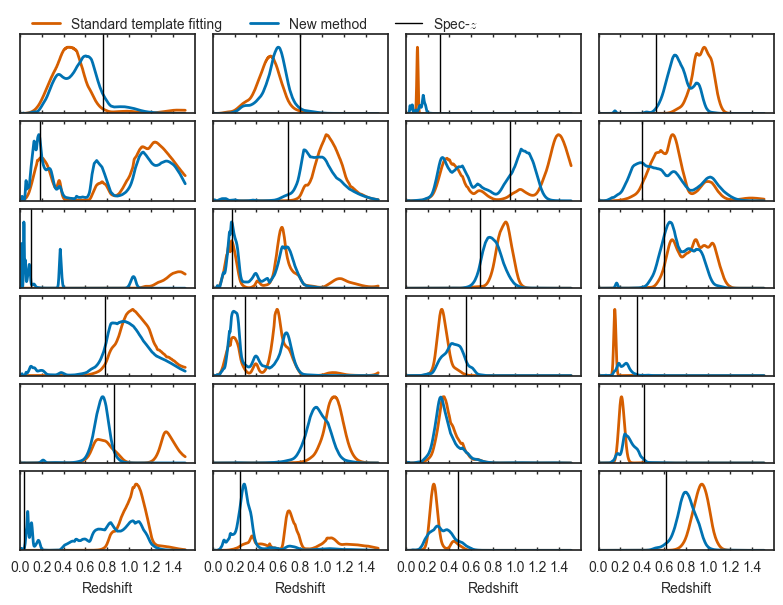

In [12]:
ncol = 4
rcParams['xtick.major.size'] = 2
rcParams['xtick.major.width'] = 1
rcParams['xtick.direction'] = 'in'
fig, axs = plt.subplots(6, ncol, figsize=(8, 6), sharex=True, sharey=False)
axs = axs.ravel()
z = fluxredshifts[:, redshiftColumn]
thres = 0.2
ind = np.abs(metricscww[:, i_zt] - metricscww[:, i_zmap]) > thres
ind &= np.abs(metrics[:, i_zt] - metrics[:, i_zmap]) < thres
sel = np.where(ind)[0]
np.random.shuffle(sel)
lw = 2
# "#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"
for ik in range(axs.size):
    k = sel[ik]
    print(k, end=" ")
    axs[ik].plot(redshiftGrid, pdfs_cww[k, :],lw=lw, label='Standard template fitting', color=colTF)# c="#2ecc71", 
    axs[ik].plot(redshiftGrid, pdfs[k, :], lw=lw, label='New method', color=colGP)  #, c="#3498db"
    if comp:
        axs[ik].plot(redshiftGrid, pdfs_comp[k, :], lw=lw, ls='dashed', label='New method (compressed)') 
    axs[ik].axvline(fluxredshifts[k, redshiftColumn], c="k", lw=1, label=r'Spec-$z$')
    ymax = np.max(np.concatenate((pdfs[k, :], pdfs_cww[k, :])))
    axs[ik].set_ylim([0, ymax*1.2])
    axs[ik].set_xlim([0, 1.6])
    axs[ik].set_yticks([])
    axs[ik].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
for i in range(ncol):
    axs[-i-1].set_xlabel('Redshift', fontsize=10)
axs[0].legend(ncol=3, frameon=False, loc='upper left', bbox_to_anchor=(0.0, 1.4))
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.96)
fig.savefig('./paper/redshiftpdfs.pdf')
rcParams['xtick.major.width'] = 0

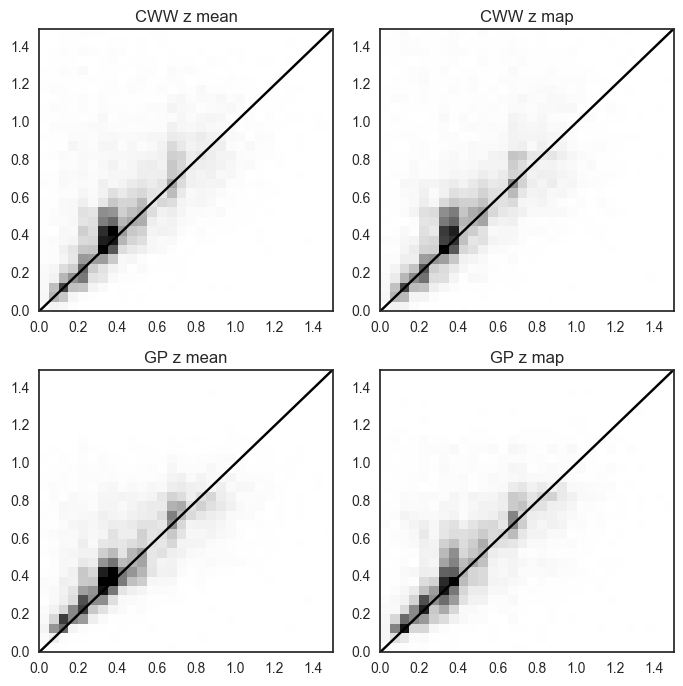

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
zmax = 1.5
rr = [[0, zmax], [0, zmax]]
nbins = 30
import matplotlib as mpl
h = axs[0, 0].hist2d(metricscww[:, i_zt], metricscww[:, i_zm], nbins, cmap='Greys', range=rr)
hmin, hmax = np.min(h[0]), np.max(h[0])
axs[0, 0].set_title('CWW z mean')
axs[0, 1].hist2d(metricscww[:, i_zt], metricscww[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[0, 1].set_title('CWW z map')
axs[1, 0].hist2d(metrics[:, i_zt], metrics[:, i_zm], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 0].set_title('GP z mean')
axs[1, 1].hist2d(metrics[:, i_zt], metrics[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 1].set_title('GP z map')
axs[0, 0].plot([0, zmax], [0, zmax], c='k')
axs[0, 1].plot([0, zmax], [0, zmax], c='k')
axs[1, 0].plot([0, zmax], [0, zmax], c='k')
axs[1, 1].plot([0, zmax], [0, zmax], c='k')
fig.tight_layout()

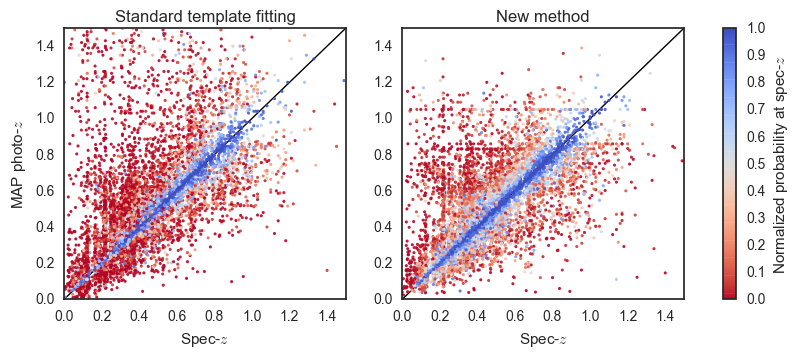

In [14]:
cmap = "coolwarm_r"
vmin = 0.0
alpha = 0.9
s = 5
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
vs = axs[0].scatter(metricscww[:, i_zt], metricscww[:, i_zmap], 
                    s=s, c=pdfatZ_cww, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
vs = axs[1].scatter(metrics[:, i_zt], metrics[:, i_zmap], 
                    s=s, c=pdfatZ, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
clb = plt.colorbar(vs, ax=axs.ravel().tolist())
clb.set_label('Normalized probability at spec-$z$')
for i in range(2):
    axs[i].plot([0, zmax], [0, zmax], c='k', lw=1, zorder=0, alpha=1)
    axs[i].set_ylim([0, zmax])
    axs[i].set_xlim([0, zmax])
    axs[i].set_xlabel('Spec-$z$')
axs[0].set_ylabel('MAP photo-$z$')

axs[0].set_title('Standard template fitting')
axs[1].set_title('New method')
fig.savefig('./paper/zmean_vs_zspec.pdf')

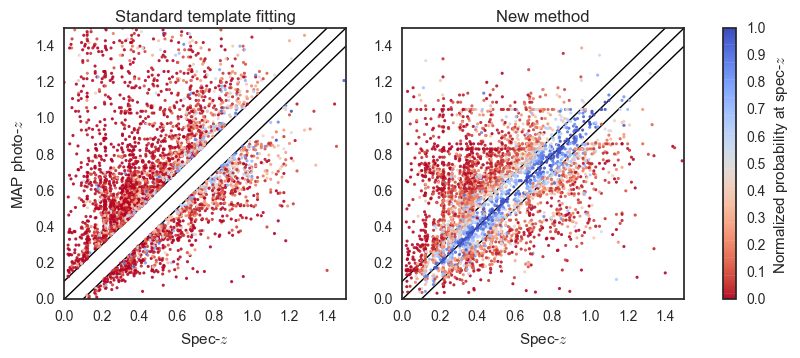

In [15]:
cmap = "coolwarm_r"
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
thres = 0.1
ind = np.abs(metricscww[:, i_zt] - metricscww[:, i_zmap]) > thres
vs = axs[0].scatter(metricscww[ind, i_zt], metricscww[ind, i_zmap], 
                    s=s, c=pdfatZ_cww[ind], cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
vs = axs[1].scatter(metrics[ind, i_zt], metrics[ind, i_zmap], 
                    s=s, c=pdfatZ[ind], cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
clb = plt.colorbar(vs, ax=axs.ravel().tolist())
clb.set_label('Normalized probability at spec-$z$')
for i in range(2):
    axs[i].plot([0, zmax], [0, zmax], c='k', lw=1, zorder=0, alpha=1)
    axs[i].plot([0, zmax], [-thres, zmax-thres], c='k', lw=1, zorder=0, alpha=1)
    axs[i].plot([-thres, zmax-thres], [0, zmax], c='k', lw=1, zorder=0, alpha=1)
    axs[i].set_ylim([0, zmax])
    axs[i].set_xlim([0, zmax])
    axs[i].set_xlabel('Spec-$z$')
axs[0].set_ylabel('MAP photo-$z$')

axs[0].set_title('Standard template fitting')
axs[1].set_title('New method')
fig.savefig('./paper/zmean_vs_zspec_outliers.pdf')

In [16]:
pdfs /= np.trapz(pdfs, x=redshiftGrid, axis=1)[:, None]
pdfs_cww /= np.trapz(pdfs_cww, x=redshiftGrid, axis=1)[:, None]

#pdfs /= pdfs.max(axis=1)[:, None]
#pdfs_cww /= pdfs_cww.max(axis=1)[:, None]

cis = np.zeros((pdfs.shape[0], ))
cis_cww = np.zeros((pdfs.shape[0], ))
for i in range(pdfs.shape[0]):
    pdfatZval = np.interp(metrics[i, i_zt], redshiftGrid, pdfs[i, :])
    ind = pdfs[i, :] >= pdfatZval
    cis[i] = np.trapz(pdfs[i, ind], x=redshiftGrid[ind])
    #if cis[i] > 1.01:
    #    print(pdfatZval, metrics[i, 0], cis[i])
    pdfatZval = np.interp(metricscww[i, i_zt], redshiftGrid, pdfs_cww[i, :])
    ind = pdfs_cww[i, :] >= pdfatZval
    cis_cww[i] = np.trapz(pdfs_cww[i, ind], x=redshiftGrid[ind])


/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater_equal


0.327477689056 0.534908877131
0.223341417408 0.387135495605
0.141782071927 0.274782608696
0.33905511811 0.391253196931


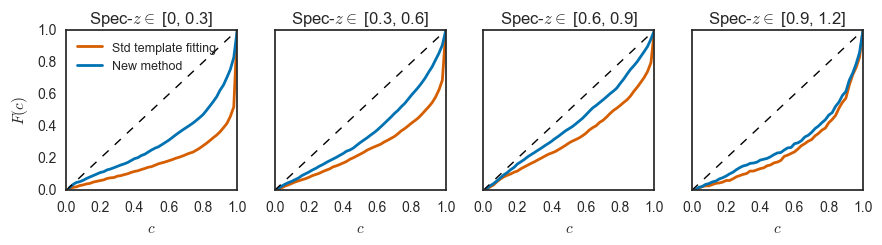

In [17]:
zbins = [0, 0.3, 0.6, 0.9, 1.2]
#zbins = [0, 0.4, 0.8, 1.2]
#zbins = [0, 1.2]
fig, axs = plt.subplots(1, 4, figsize=(9, 2.6), sharey=True)
axs = axs.ravel()
nbins = 50
for i, (zlo, zhi) in enumerate(zip(zbins[:-1], zbins[1:])):
    ind = np.logical_and(metricscww[:, 0] >= zlo, metricscww[:, 0] < zhi)
    cis_pdf, e = np.histogram(cis[ind], nbins, range=[0, 1])
    cis_pdfcum = np.cumsum(cis_pdf) / np.sum(cis_pdf)
    cis_cww_pdf, ce = np.histogram(cis_cww[ind], nbins, range=[0, 1])
    cis_cww_pdfcum = np.cumsum(cis_cww_pdf) / np.sum(cis_cww_pdf)
    print(np.max(np.abs(e[1:] - cis_pdfcum)), np.max(np.abs(ce[1:] - cis_cww_pdfcum)))
    axs[i].plot(ce[1:], cis_cww_pdfcum, lw=2, label='Std template fitting', color=colTF)
    axs[i].plot(e[1:], cis_pdfcum, lw=2, label='New method', color=colGP)
    axs[i].set_xlim([0, 1])
    axs[i].set_ylim([0, 1])
    axs[i].set_xlabel('$c$')
    axs[i].plot([0, 1], [0, 1], 'k', ls='dashed', lw=1)
    axs[i].set_title('Spec-$z \in$ ['+str(zlo)+', '+str(zhi)+']')
axs[0].set_ylabel('$F(c)$')
axs[0].legend(loc='upper left', fontsize=9)
fig.tight_layout()
fig.savefig('./paper/cipdfs.pdf')

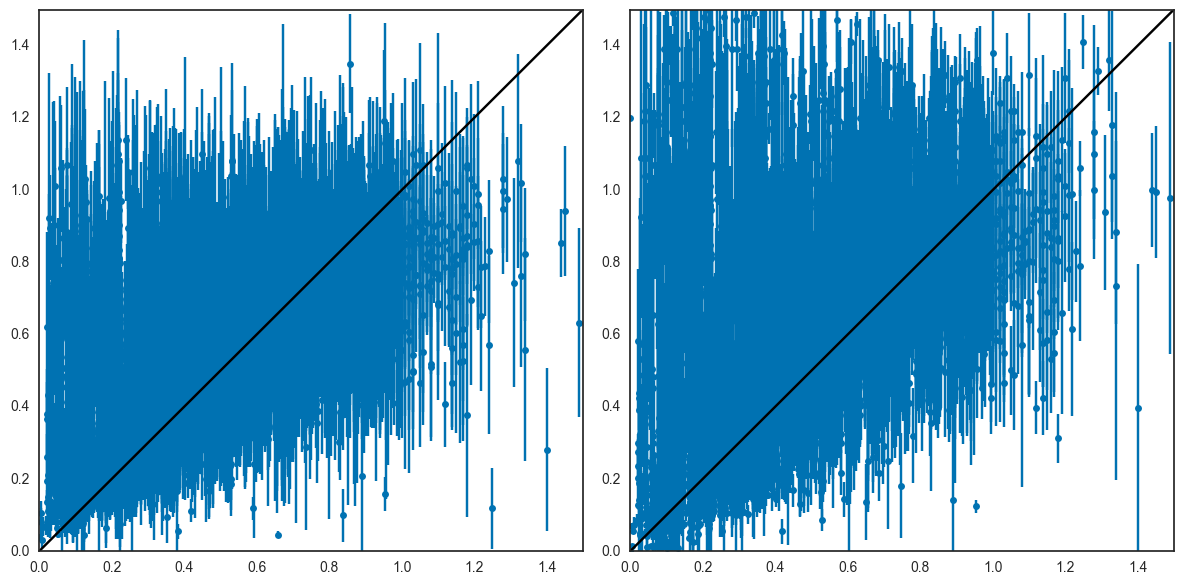

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
chi2s = ((metrics[:, i_zt] - metrics[:, i_ze])/metrics[:, i_std_ze])**2

#sc = axs[0].scatter(metrics[:, i_zt], metrics[:, i_ze], c=chi2s, cmap="jet")
#clb = plt.colorbar(sc)
#clb.set_clim(0, 10)
#a,b,c = axs[0].errorbar(metrics[:, i_zt], metrics[:, i_ze], yerr=metrics[:, i_std_ze], marker='', ls='', zorder=0)
#colors = clb.to_rgba(chi2s)
#c[0].set_color(colors)
axs[0].errorbar(metrics[:, i_zt], metrics[:, i_ze], yerr=metrics[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[1].errorbar(metricscww[:, i_zt], metricscww[:, i_ze], yerr=metricscww[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[0].plot([0, zmax], [0, zmax], 'k')
axs[1].plot([0, zmax], [0, zmax], 'k')
axs[0].set_xlim([0, zmax])
axs[1].set_xlim([0, zmax])
axs[0].set_ylim([0, zmax])
axs[1].set_ylim([0, zmax])

fig.tight_layout()

In [19]:
chi2s = np.loadtxt('/Users/bl/Dropbox/repos/PhotoZviaGP/data/galaxies-gpCV.txt')
gpparams = np.loadtxt('/Users/bl/Dropbox/repos/PhotoZviaGP/data/galaxies-gpparams.txt')
ells = gpparams[:, 2]
z = gpparams[:, 1]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/bl/Dropbox/repos/PhotoZviaGP/data/galaxies-gpCV.txt'

In [ ]:
nbs = gpparams[:, 0].astype(int)
ii = np.arange(gpparams.shape[0])
types = 0*nbs
for t in range(8):
    ind = gpparams[[ii, 3+nbs+t]] == 1
    types[ind] = t
np.bincount(types)

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(12, 5))
axs = axs.ravel()
for t in range(8):
    ind = types == t
    axs[t].hist(z[ind], histtype='step', normed=True, range=[0, 1.5], lw=2)
    axs[t].set_title(sed_names[t].replace('_', ' '))
fig.tight_layout()

In [ ]:
from scipy.stats import chi2 as chi2
fig, axs= plt.subplots(5, redshiftDistGrid.size-1, figsize=(16, 6), sharex=True, sharey=True)
cmax = 15 #np.max(-0.5*chi2s)
x = np.linspace(0.1, cmax, 100)
for k, (zlo, zhi) in enumerate(zip(redshiftDistGrid[:-1], redshiftDistGrid[1:])): 
    ind = np.logical_and(z >= zlo, z <= zhi)
    if ind.sum() > 1:
        axs[0, k].set_title(ind.sum())
        for i in range(5):
            axs[i, k].hist(-2*chi2s[ind, i], 20, histtype='step', log=True, normed=True, range=[0, cmax], lw=2)
            axs[i, k].plot(x, chi2.pdf(x, 1))
            axs[i, k].set_ylim([1e-3, 2.0])
fig.tight_layout()

In [ ]:
fig, ax= plt.subplots(1, 1, figsize=(4, 3), sharex=True, sharey=True)
ax.hist(-2*chi2s.sum(axis=1), 20, histtype='step', log=True, normed=True, range=[0, cmax], lw=2)
ax.plot(x, chi2.pdf(x, 5))
ax.set_ylim([1e-3, 2.0])
fig.tight_layout()


fig, axs= plt.subplots(1, 5, figsize=(12, 3), sharex=True, sharey=True)
for i in range(5):
    axs[i].hist(-2*chi2s[:, i], 20, histtype='step', log=True, normed=True, range=[0, cmax], lw=2)
    axs[i].plot(x, chi2.pdf(x, 1))
    axs[i].set_ylim([1e-3, 2.0])
fig.tight_layout()